# Imports

In [1]:
# install required libraries
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk import sent_tokenize
from nltk.data import find
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('tagsets_json')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')  # POS tagger model
nltk.download('averaged_perceptron_tagger_eng')  # POS tagger model

import nltk

from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')
POS_TAGS = tagdict.keys()

[nltk_data] Downloading package punkt to /home/jortg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jortg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package tagsets_json to
[nltk_data]     /home/jortg/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!
[nltk_data] Downloading package tagsets to /home/jortg/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jortg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/jortg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


# Loading the data

In [3]:
data_folder_name = 'A4data_2526_pan2020'
DATA_FOLDER = Path(data_folder_name)
DEV_SET = None
TEST_SET = None
TRAIN_SET = None

if not DATA_FOLDER.exists():
    print(f"ERROR: Data folder not found, make sure the '/{data_folder_name}' folder is located in the same folder as this notebook!")
else:
    try:
        DEV_SET = pd.read_csv(DATA_FOLDER / 'pan2526_dev_data.csv')
        TEST_SET = pd.read_csv(DATA_FOLDER / 'pan2526_test_data.csv')
        TRAIN_SET = pd.read_csv(DATA_FOLDER / 'pan2526_train_data.csv')
        print('Data loaded successfully')
    except FileNotFoundError:
        print(f"ERROR: Data not found in '/{DATA_FOLDER}'")
    

Data loaded successfully


Let's have a look at the DEV data:

In [4]:
DEV_SET

,Unnamed: 0,text,author
0,3329,The last part of the pictorial will now begin!...,560480
1,1225,"""It is a huge body of water."" It was slow yet ...",560480
2,3334,"As she reached for the door, the sound of a ca...",512464
3,3573,Despite the scowl that seemed to be forever pl...,2750536
4,1429,The traditional institutions did not take the ...,1112924
...,...,...,...
263,1432,"""Still thinking about it, Kuwabara-jiisan,"" Hi...",1112924
264,1838,"""Well, if it isn""t tha"" police kitteh."" Seras ...",1220273
265,3328,"""I think I have seen that clothes before..."" L...",560480
266,470,"""I almost didn""t turn away from you, even when...",1220273


# Extract features

In [5]:
def pos_tagger(sentences):
    return [nltk.pos_tag(word_tokenize(sent)) for sent in sentences]

def prepare(data_frame):
    data_frame['snippet_length'] = data_frame['text'].str.len()
    
    data_frame['tokens'] = data_frame['text'].apply(
        lambda x: word_tokenize(x.lower())
    )
    data_frame['token_count'] = data_frame['tokens'].apply(
        lambda x: len(x)
    )
    data_frame['sentences'] = data_frame['text'].apply(
        lambda x: sent_tokenize(x.lower())
    )
    data_frame['sentence_count'] = data_frame['sentences'].apply(
        lambda x: len(x)
    )
    data_frame['pos_tagged_sentences'] = data_frame['sentences'].apply(
        lambda x: pos_tagger(x)
    )
    return data_frame

In [6]:
def tag_counter(pos_tagged_sentences, tag):
    tag_sum = 0
    for sentence in pos_tagged_sentences:
        for token_tag_pair in sentence:
            if token_tag_pair[1] == tag:
                tag_sum += 1
    return tag_sum

In [7]:
def get_pos_features(data_frame):
    chosen_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 
'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS',
'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG',
'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
    
    
    assert 'pos_tagged_sentences' in data_frame.columns
    
    feature_names = []
    
    for tag in chosen_tags:
        feature_name = f'pf_{tag}'
    
        data_frame[feature_name] = data_frame['pos_tagged_sentences'].apply(
            lambda x: tag_counter(x, tag)
        ) / data_frame['token_count']

    tag_sums = {}
    for tag in chosen_tags:
        feature_name = f'pf_{tag}'
        tag_sums[tag] = data_frame[feature_name].sum()
    
    top_tags = sorted(tag_sums, key=tag_sums.get, reverse=True)[:10]
    print(f'top_keys: {top_tags}')
    for tag in top_tags:
        feature_name = f'pf_{tag}'
        feature_names.append(feature_name)
        print(f'{tag}: {data_frame[feature_name].sum()}')
    
    return data_frame, feature_names
    

In [8]:
# def tokenize(data_frame):
#     data_frame['tokenized'] = data_frame['text'].apply(
#         lambda x: word_tokenize(x.lower())
#     )
#     return data_frame
    
    

In [9]:
def get_char_features(data_frame):
    # some char count fetaures
    
    data_frame['cf_comma'] = data_frame['text'].str.count(r',') / data_frame['snippet_length']
    data_frame['cf_period'] = data_frame['text'].str.count(r'\.') / data_frame['snippet_length']
    data_frame['cf_exclam'] = data_frame['text'].str.count(r'\!') / data_frame['snippet_length']
    data_frame['cf_question'] = data_frame['text'].str.count(r'\?') / data_frame['snippet_length']
    data_frame['cf_upper_case'] = data_frame['text'].str.count(r'[A-Z]') / data_frame['snippet_length']
    data_frame['cf_lower_case'] = data_frame['text'].str.count(r'[a-z]') / data_frame['snippet_length']
    
    # some aggregated char count features
    data_frame['cf_vowel_frequency'] = data_frame['text'].str.count(r'[aeiou]') / data_frame['snippet_length']
    data_frame['cf_avg_word_len'] = data_frame['text'].apply(lambda x: sum(len(w) for w in x.split()) / len(x.split()) if x.split() else 0)
    
    # make sure any features you want to be used during training are also in this list:
    feature_names = [
        'cf_comma', 
        'cf_period', 
        'cf_exclam', 
        'cf_question', 
        'cf_upper_case',
        'cf_lower_case',
        'cf_vowel_frequency',
        'cf_avg_word_len'
    ]
    
    return data_frame, feature_names

In [10]:
def get_word_features(data_frame):
    # count number of words
    data_frame['wf_word_count'] = data_frame['text'].apply(
        lambda x: len(x.split())
    )
    # count the stopwords
    stop_words = set(stopwords.words('english'))
    data_frame['wf_stopword_frequency'] = data_frame['text'].apply(
        lambda x: sum(1 for w in word_tokenize(x.lower()) if w in stop_words)
    ) / data_frame['wf_word_count']
    
    # make sure any features you want to be used during training are also in this list:
    feature_names = [
        'wf_word_count', 
        'wf_stopword_frequency'
    ]
    
    return data_frame, feature_names

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_bow_features(data_frame, vectorizer=None):
    if vectorizer is None:
        #normalizing the score and extracting only the top 10 words
        vectorizer = TfidfVectorizer(max_features=10)
        matrix = vectorizer.fit_transform(data_frame['text'])
    else:
        matrix = vectorizer.transform(data_frame['text'])
    feature_names = [
        f'Tfidf_{w}' for w in vectorizer.get_feature_names_out()
    ]
    bow_df = pd.DataFrame(matrix.toarray(), columns=feature_names, index=data_frame.index)
    data_frame = pd.concat([data_frame, bow_df], axis=1)
    return data_frame, feature_names, vectorizer



In [12]:
def extract_features_old(data_frame):
    """extracts relevant features"""
    # prepare text (like tokenizing)
    data_frame = prepare(data_frame)
    print(data_frame.head())
    # list of feature names we want to use for training
    feature_names = []
    
    # extract some character based features
    data_frame, ft_names = get_char_features(data_frame)
    feature_names += ft_names
    
    # extract stop word based features
    data_frame, ft_names = get_word_features(data_frame)
    feature_names += ft_names
    
    # extract POS features
    data_frame, ft_names = get_pos_features(data_frame)
    feature_names += ft_names

    #extract bag of words feature using the top 10 words
    data_frame, ft_names, vectorizer = get_bow_features(data_frame)
    feature_names += ft_names 
    
    # return the data with the features and the list of feature names
    return data_frame, feature_names

In [13]:
def extract_features(data_frame, vectorizer=None):
    """extracts relevant features"""
    # prepare text (like tokenizing)
    data_frame = prepare(data_frame)
    print(data_frame.head())
    # list of feature names we want to use for training
    feature_names = []
    feature_groups = {}
    
    # extract some character based features
    data_frame, ft_names = get_char_features(data_frame)
    feature_names += ft_names
    feature_groups["char_features"] = ft_names
    # extract stop word based features
    data_frame, ft_names = get_word_features(data_frame)
    feature_names += ft_names
    feature_groups["word_features"] = ft_names
    
    # extract POS features
    data_frame, ft_names = get_pos_features(data_frame)
    feature_names += ft_names
    feature_groups["pos_features"] = ft_names

    #extract bag of words feature using the top 10 words
    data_frame, ft_names, vectorizer = get_bow_features(data_frame, vectorizer=vectorizer)
    feature_names += ft_names
    feature_groups["Tfidf_features"] = ft_names
    
    # return the data with the features and the list of feature names
    return data_frame, feature_names, feature_groups, vectorizer

In [14]:
class Model:
    """
    A wrapper class that is meant to wrap around an arbitrary machine learning model
    """
    def __init__(self, X_train, y_train, feature_names, *args, verbose=False, **kwargs):
        self.args=args
        self.kwargs=kwargs
        self.X_train=X_train[feature_names]
        self.y_train=y_train
        self.feature_names=feature_names
        self.verbose=verbose
    
    def fit(self):
        raise NotImplementedError

    def _test(self):
        raise NotImplementedError
    
    def _score_fn(self):
        raise NotImplementedError
        
    def predict(self, X_test, y_test):
        self.X_test=X_test[self.feature_names]
        self.y_test=y_test
        return self._test()
    
    def score(self, X_test, y_test):
        self.X_test=X_test[self.feature_names]
        self.y_test=y_test
        return self._score_fn()
    
    @classmethod
    def train_and_score(cls, X_train, y_train, X_test, y_test, feature_names, *args, verbose=False, **kwargs):
        model = cls(X_train, y_train, feature_names, *args, verbose=verbose, **kwargs)
        model.fit()
        return model.score(X_test, y_test)
    

class DecisionTree(Model):
    """
    Wrapper for the sklearn DecisionTree
    """
    def fit(self):
        self.model = DecisionTreeClassifier(*self.args, **self.kwargs)
        self.model.fit(self.X_train, self.y_train)
        
    def _test(self):
        # Make predictions
        return self.model.predict(self.X_test)
    
    def _score_fn(self):
        return self.model.score(self.X_test, self.y_test)
    
class RandomForest(Model):
    """
    Wrapper for the sklearn RandomForest
    """
    def fit(self):
        self.model = RandomForestClassifier(*self.args, **self.kwargs)
        self.model.fit(self.X_train, self.y_train)
        
    def _test(self):
        # Make predictions for the test set
        return self.model.predict(self.X_test)
    
    def _score_fn(self):
        # Get the accuracy on the test set
        return self.model.score(self.X_test, self.y_test)
    
class CatBoost(Model):
    def fit(self):
        self.model = CatBoostClassifier(
            iterations=self.kwargs['iterations'],         # number of boosting rounds
            learning_rate=self.kwargs['learning_rate'],   # smaller = more stable, slower
            depth=self.kwargs['depth'],                   # tree depth
            loss_function=self.kwargs['loss_function'],   # for multi-author classification
            verbose=100,                        # print progress every 100 iterations
            random_seed=42
        )
        self.model.fit(self.X_train, self.y_train)
        
    def _test(self):
        # Make predictions for the test set
        return self.model.predict(self.X_test)
    
    def _score_fn(self):
        # Get the accuracy on the test set
        y_pred = self.model.predict(self.X_test)
        return accuracy_score(self.y_test, y_pred)
        
    

In [15]:

# create all the necessary features for the DEV set:
dev_with_features, dev_feature_names, dev_feature_groups, dev_vectorizer = extract_features(DEV_SET)
print(dev_feature_groups)

   Unnamed: 0                                               text   author  \
0        3329  The last part of the pictorial will now begin!...   560480   
1        1225  "It is a huge body of water." It was slow yet ...   560480   
2        3334  As she reached for the door, the sound of a ca...   512464   
3        3573  Despite the scowl that seemed to be forever pl...  2750536   
4        1429  The traditional institutions did not take the ...  1112924   

   snippet_length                                             tokens  \
0            3094  [the, last, part, of, the, pictorial, will, no...   
1            3072  [``, it, is, a, huge, body, of, water, ., '', ...   
2            2878  [as, she, reached, for, the, door, ,, the, sou...   
3            3095  [despite, the, scowl, that, seemed, to, be, fo...   
4            3044  [the, traditional, institutions, did, not, tak...   

   token_count                                          sentences  \
0          749  [the last part of t

In [16]:
def ablation_test(model_type:Model, X_train, X_test, y_train, y_test, feature_names, feature_groups, ax, is_last, *args, **kwargs):

    scores = {}
    colors = []
    alphas = []
    # get the base score when using all features:
    scores['None'] = model_type.train_and_score(
        *args,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_names=feature_names,
        **kwargs
    )
    colors.append('C0')
    alphas.append(1)
    # perform the actual ablation tests:
    for i, feature_group in enumerate(feature_groups):
        prettified_feature_group_name = f'all {feature_group.replace("_", " ") }'
        group_features = feature_groups[feature_group]
        # remove all group features
        ablated_feature_names = feature_names.copy() 
        for feature in group_features:
            ablated_feature_names.remove(feature)  
        
        # train and test the model
         
        scores[prettified_feature_group_name] = model_type.train_and_score(
            *args,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            feature_names=ablated_feature_names,
            **kwargs
        )
        colors.append(f'C{i+1}')
        alphas.append(1)
    
        # remove one by one
        for feature in group_features:
            # copy the feature list and remove one:
            ablated_feature_names = feature_names.copy() 
            ablated_feature_names.remove(feature)  
            
            # for nicer printing in the plot func:
            prettified_feature_name = feature.replace("_", " ")  
            
            # train and test the model
            scores[prettified_feature_name] = model_type.train_and_score(
                *args,
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                feature_names=ablated_feature_names,
                **kwargs
            )
            colors.append(f'C{i+1}')
            alphas.append(0.5)
        
    
    bars = ax.bar(scores.keys(), scores.values())
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
        bar.set_alpha(alphas[i])
    #bars[0].set_color('C1')
    if is_last:
        for i, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(45)
            label.set_ha('right')
            if alphas[i] == 1:
                label.set_fontweight('bold')
        ax.set_xlabel('Ablated feature')
    else:
        ax.set_xticks([])
    ax.set_ylabel('Accuracy')
    
    ax.set_title(f'{model_type.__name__}')
    

In [17]:
def train_and_test_all(
    X_train,
    X_test, 
    y_train,
    y_test,
    feature_names,
    feature_groups
):# dictionary with the selected model types and their optional arguments:

    
    model_dict = {
        DecisionTree: {
            'args': [],
            'kwargs': {}
        },
        RandomForest:{
            'args': [],
            'kwargs': {'n_estimators': 100}
        },
        CatBoost: {
            'args': [],
            'kwargs': {
                'iterations': 300,
                'learning_rate': 0.05,
                'depth':6,
                'loss_function':'MultiClass'
            }
        }
    }
    n_models=len(model_dict)
    fig, axs = plt.subplots(n_models,1, figsize=(12,3*n_models))
    print(len(axs))
    print(f'Training and testing {n_models} models')
    # perform an ablation test on each type of model
    for i, (model_type, args_kwargs) in enumerate(model_dict.items()):

        print(f'Model {model_type.__name__}:')
        ablation_test(
            *args_kwargs["args"],
            model_type=model_type,
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            feature_names=feature_names,
            feature_groups=feature_groups,
            ax=axs[i],
            is_last=i==n_models-1,
            **args_kwargs["kwargs"]
        )
    plt.suptitle('Ablation Results')
    plt.tight_layout()
    plt.show()



In [18]:

def evaluate_on_dev():
    dev_with_features, dev_feature_names, dev_feature_groups, vectorizer = extract_features(DEV_SET)
    X_dev = dev_with_features[dev_feature_names]
    y_dev = dev_with_features['author']
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)
    train_and_test_all(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        feature_names=dev_feature_names,
        feature_groups=dev_feature_groups
    )

In [19]:
def evaluate_on_train_test():
    train_with_features, train_feature_names, train_feature_groups, train_vectorizer = extract_features(TRAIN_SET)
    X_train = train_with_features[train_feature_names]
    y_train = train_with_features['author']
    test_with_features, test_feature_names, test_feature_groups, _ = extract_features(TEST_SET, vectorizer=train_vectorizer)
    X_test = test_with_features[test_feature_names]
    y_test = test_with_features['author']
    train_and_test_all(
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        feature_names=train_feature_names,
        feature_groups=train_feature_groups
    )

   Unnamed: 0                                               text   author  \
0        3329  The last part of the pictorial will now begin!...   560480   
1        1225  "It is a huge body of water." It was slow yet ...   560480   
2        3334  As she reached for the door, the sound of a ca...   512464   
3        3573  Despite the scowl that seemed to be forever pl...  2750536   
4        1429  The traditional institutions did not take the ...  1112924   

   snippet_length                                             tokens  \
0            3094  [the, last, part, of, the, pictorial, will, no...   
1            3072  [``, it, is, a, huge, body, of, water, ., '', ...   
2            2878  [as, she, reached, for, the, door, ,, the, sou...   
3            3095  [despite, the, scowl, that, seemed, to, be, fo...   
4            3044  [the, traditional, institutions, did, not, tak...   

   token_count                                          sentences  \
0          749  [the last part of t

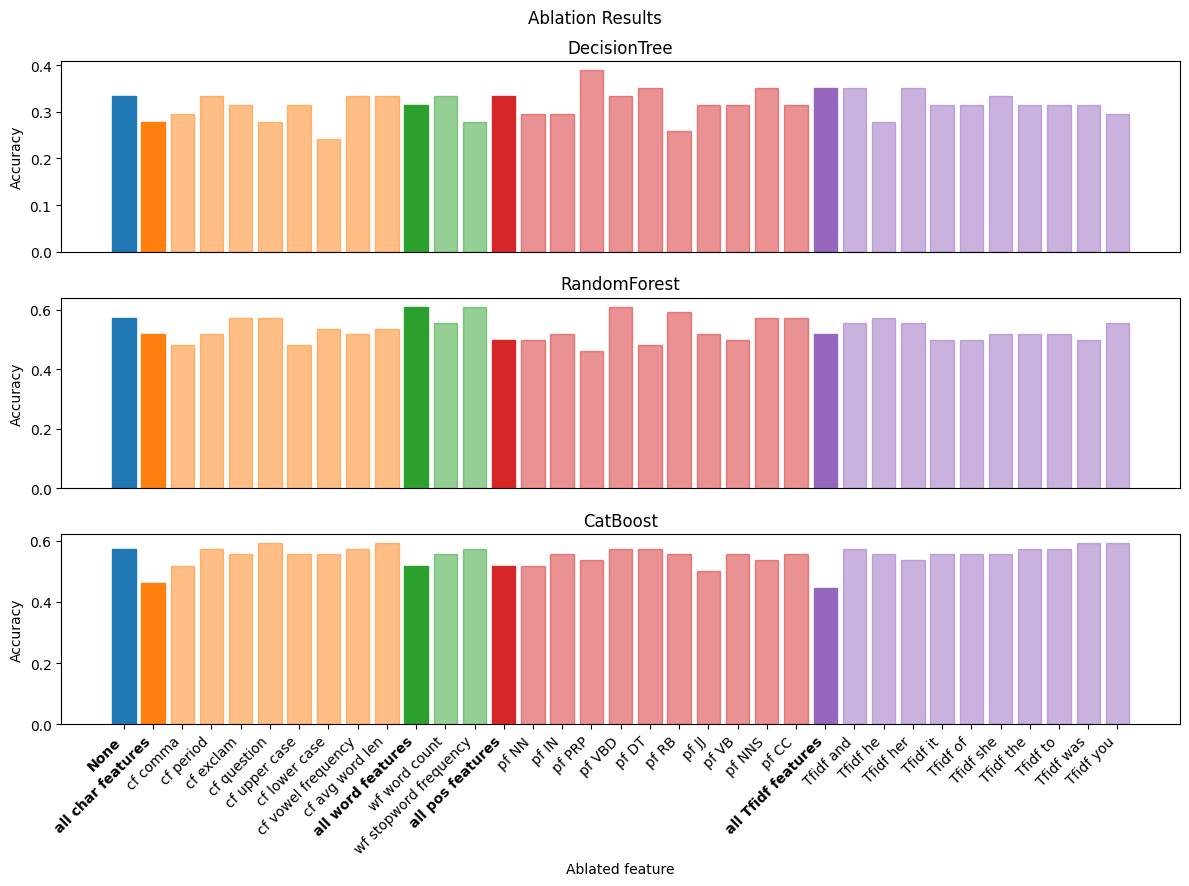

In [20]:
evaluate_on_dev()